# Create interface with minimal energy among surfaces with different Miller indices

This notebook takes two materials, cycles through Miller indices and constructs a coherent interface using ZSL algorithm, optimizes it with a relaxer and calculator, and then calculates the delta energy for the interface. The delta energy is then plotted as a function of the Miller index.

## 1. Setup
Set the maximum Miller indices for the substrate, and the settings for the interface, relaxation, and ZSL algorithm.

In [32]:
MAX_MILLER = {
    "H": 1,
    "K": 1,
    "L": 1,
}

USE_CONVENTIONAL_CELL = True

SETTINGS = {
    "SUBSTRATE_PARAMETERS": {
        "MATERIAL_INDEX": 0,  # the index of the material in the materials_in list
        "MILLER_INDICES": (1, 1, 1),  # the miller indices of the interfacial plane
        "THICKNESS": 3,  # in layers
    },
    "LAYER_PARAMETERS": {
        "MATERIAL_INDEX": 1,  # the index of the material in the materials_in list
        "MILLER_INDICES": (0, 0, 1),  # the miller indices of the interfacial plane
        "THICKNESS": 1,  # in layers
    },
    "INTERFACE_PARAMETERS": {
        "DISTANCE_Z": 3.0,  # in Angstroms
    },
    "ZSL_PARAMETERS": {
        "MAX_AREA": 81,  # The area to consider in Angstrom^2
        "MAX_AREA_TOL": 0.09,  # The area within this tolerance is considered equal
        "MAX_LENGTH_TOL": 0.03,  # supercell lattice vectors lengths within this tolerance are considered equal
        "MAX_ANGLE_TOL": 0.01,  # supercell lattice angles within this tolerance are considered equal
        "STRAIN_TOL": 10e-6,  # strains within this tolerance are considered equal
    },
    "RELAXATION_PARAMETERS": {
        "RELAXER": "BFGS",  # The relaxation algorithm to use
        "CALCULATOR": "EMT",  # The calculator to use
        "FMAX": 0.05,  # The maximum force allowed on each atom
    }
}


## 2. Definitions
Functions definitions to create the interfaces, sort them, relax them, and calculate the effective delta energy.

In [33]:
from src.pymatgen_coherent_interface_builder import CoherentInterfaceBuilder, ZSLGenerator
from src.utils import ase_to_poscar, pymatgen_to_ase, to_pymatgen, get_interfacial_energy
from ase.optimize import BFGS
from ase.calculators.emt import EMT

# Type hinting
from collections.abc import Sequence
from ase.optimize.optimize import Optimizer
from ase.calculators.calculator import Calculator
from ase import Atoms
from pymatgen.core import Structure

OPTIMIZER_MAP = {"BFGS": BFGS}
CALCULATOR_MAP = {"EMT": EMT()}


def create_interfaces(materials: Sequence[Structure], settings):
    """Create interfaces for the given materials and settings."""
    print("Creating interfaces...")
    zsl = ZSLGenerator(
        max_area_ratio_tol=settings["ZSL_PARAMETERS"]["MAX_AREA_TOL"],
        max_area=settings["ZSL_PARAMETERS"]["MAX_AREA"],
        max_length_tol=settings["ZSL_PARAMETERS"]["MAX_LENGTH_TOL"],
        max_angle_tol=settings["ZSL_PARAMETERS"]["MAX_ANGLE_TOL"],
    )

    cib = CoherentInterfaceBuilder(
        substrate_structure=materials[settings["SUBSTRATE_PARAMETERS"]["MATERIAL_INDEX"]],
        film_structure=materials[settings["LAYER_PARAMETERS"]["MATERIAL_INDEX"]],
        substrate_miller=settings["SUBSTRATE_PARAMETERS"]["MILLER_INDICES"],
        film_miller=settings["LAYER_PARAMETERS"]["MILLER_INDICES"],
        zslgen=zsl,
        strain_tol=settings["ZSL_PARAMETERS"]["STRAIN_TOL"],
    )

    # Find terminations
    cib._find_terminations()
    terminations = cib.terminations

    # Create interfaces for each termination
    interfaces = {}
    for termination in terminations:
        interfaces[termination] = []
        for interface in cib.get_interfaces(
                termination,
                gap=settings["INTERFACE_PARAMETERS"]["DISTANCE_Z"],
                film_thickness=settings["LAYER_PARAMETERS"]["THICKNESS"],
                substrate_thickness=settings["SUBSTRATE_PARAMETERS"]["THICKNESS"],
                in_layers=True,
        ):
            # Wrap atoms to unit cell
            interface["interface"].make_supercell((1, 1, 1), to_unit_cell=True)
            interfaces[termination].append(interface)
    return interfaces, terminations


# Sort interfaces by the specified strain mode and number of sites
def sort_interfaces(interfaces: dict, terminations: list, strain_mode="mean_abs_strain"):
    sorted_interfaces = {}
    for termination in terminations:
        sorted_interfaces[termination] = sorted(
            interfaces[termination], key=lambda x: (x[strain_mode], x["interface"].num_sites)
        )
    return sorted_interfaces


def relax_structure(atoms: Atoms, optimizer: Optimizer, calculator: Calculator, fmax: float=0.05, verbose: bool = False):
    # Set up the interface for relaxation
    ase_structure = atoms.copy()
    ase_structure.set_calculator(calculator)
    dyn = optimizer(ase_structure)
    dyn.run(fmax=fmax)

    # Extract results
    ase_original_structure = atoms
    ase_original_structure.set_calculator(calculator)
    ase_final_structure = ase_structure
    relaxed_energy = ase_structure.get_total_energy()

    # Print out the final relaxed structure and energy
    if verbose:
        print('Original structure:\n', ase_to_poscar(ase_original_structure))
        print('\nRelaxed structure:\n', ase_to_poscar(ase_final_structure))
        print(f"The final energy is {float(relaxed_energy):.3f} eV.")

    return ase_final_structure, relaxed_energy


def filter_atoms_by_tag(atoms: Atoms, material_index: int):
    """Filter atoms by their tag, corresponding to the material index."""
    return atoms[atoms.get_tags() == material_index]


def create_relaxed_interface_with_min_strain(materials: Sequence[Structure], settings: dict, optimizer: Optimizer,
                                             calculator: Calculator):
    """Creates an interface with minimal strain using ZSL and relaxes it using specified optimizer and calculator."""
    interfaces, terminations = create_interfaces(
        materials=materials,
        settings=settings
    )
    sorted_interfaces = sort_interfaces(interfaces, terminations)
    # TODO: try for every termination
    termination_index = 0
    interface_index = 0
    termination = terminations[termination_index]
    interface = sorted_interfaces[termination][interface_index]["interface"]

    ase_interface = pymatgen_to_ase(interface)
    ase_final_interface, relaxed_energy = relax_structure(
        atoms=ase_interface,
        optimizer=optimizer,
        calculator=calculator,
        fmax=settings["RELAXATION_PARAMETERS"]["FMAX"],
        verbose=True  # Assuming you want to print details
    )

    ase_substrate = filter_atoms_by_tag(ase_final_interface, settings["SUBSTRATE_PARAMETERS"]["MATERIAL_INDEX"])
    ase_layer = filter_atoms_by_tag(ase_final_interface, settings["LAYER_PARAMETERS"]["MATERIAL_INDEX"])
    ase_substrate_bulk = pymatgen_to_ase(materials[settings["SUBSTRATE_PARAMETERS"]["MATERIAL_INDEX"]])
    ase_layer_bulk = pymatgen_to_ase(materials[settings["LAYER_PARAMETERS"]["MATERIAL_INDEX"]])

    interfacial_energy = get_interfacial_energy(
        ase_final_interface,
        ase_substrate,
        ase_substrate_bulk,
        ase_layer,
        ase_layer_bulk,
        calculator
    )

    return ase_final_interface, relaxed_energy, interfacial_energy

## 3. Import materials
From the materials_list folder import the materials in ESSE format.

In [34]:
import os
import json
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer   
materials_in = []
current_folder = os.getcwd()
print(current_folder)
input_folder = "uploads"
for file in ["Ni.json", "Gr.json"]:
    with open(f"{current_folder}/{input_folder}/{file}", "r") as f:
        data = f.read()
        materials_in.append(json.loads(data))

if "materials_in" in globals():
    pymatgen_materials = [to_pymatgen(item) for item in materials_in]
    if USE_CONVENTIONAL_CELL : pymatgen_materials = [SpacegroupAnalyzer(item).get_conventional_standard_structure() for item in pymatgen_materials]
for material in pymatgen_materials:
    print(material, "\n")


/Users/mat3ra/code/GREEN/api-examples/other/experiments
Full Formula (Ni4)
Reduced Formula: Ni
abc   :   3.478965   3.478965   3.478965
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (4)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Ni    0    0    0
  1  Ni    0    0.5  0.5
  2  Ni    0.5  0    0.5
  3  Ni    0.5  0.5  0 

Full Formula (C2)
Reduced Formula: C
abc   :   2.467291   2.467291  20.000000
angles:  90.000000  90.000000 120.000000
pbc   :       True       True       True
Sites (2)
  #  SP           a         b    c
---  ----  --------  --------  ---
  0  C     0.333333  0.666667    0
  1  C     0.666667  0.333333    0 


## 4. Create relaxed interfaces with minimal energy among surfaces with different Miller indices
Cycle through HKL indices to create all matching interfaces with minimal strain

In [35]:
optimizer = OPTIMIZER_MAP[SETTINGS["RELAXATION_PARAMETERS"]["RELAXER"]]
calculator = CALCULATOR_MAP[SETTINGS["RELAXATION_PARAMETERS"]["CALCULATOR"]]

results = []
# Cycle through HKL indices for substrate and (0,0,1) for layer
for h in range(0, MAX_MILLER["H"] + 1):
    for k in range(0, MAX_MILLER["K"] + 1):
        for l in range(0, MAX_MILLER["L"] + 1):
            if h == 0 and k == 0 and l == 0:
                continue
            SETTINGS["SUBSTRATE_PARAMETERS"]["MILLER_INDICES"] = (h, k, l)

            print(
                f"Creating interface for substrate ({h},{k},{l}) and layer {SETTINGS['LAYER_PARAMETERS']['MILLER_INDICES']}")
            interface, relaxed_energy, effective_delta_energy = create_relaxed_interface_with_min_strain(
                materials=pymatgen_materials,
                settings=SETTINGS,
                optimizer=optimizer,
                calculator=calculator
            )
            print(f"Delta energy: {effective_delta_energy:.3f} eV/Å^2 ({effective_delta_energy / 0.16:.3f} J/m^2)")
            results.append([(h, k, l), effective_delta_energy, interface])


Creating interface for substrate (0,0,1) and layer (0, 0, 1)
Creating interfaces...
      Step     Time          Energy         fmax
BFGS:    0 19:45:23       12.072153        0.4084
BFGS:    1 19:45:23       12.047577        0.3556
BFGS:    2 19:45:23       11.977848        0.2338
BFGS:    3 19:45:23       11.961847        0.2759
BFGS:    4 19:45:23       11.908402        0.3204
BFGS:    5 19:45:23       11.849632        0.3379
BFGS:    6 19:45:23       11.722813        0.6200
BFGS:    7 19:45:24       11.389097        0.9390
BFGS:    8 19:45:24       10.993880        0.9987
BFGS:    9 19:45:24       11.008947        1.1773
BFGS:   10 19:45:24       10.486326        0.5182
BFGS:   11 19:45:24       10.191255        0.4510
BFGS:   12 19:45:24       10.010068        0.6740
BFGS:   13 19:45:24        9.823835        0.7836
BFGS:   14 19:45:24        9.597598        0.7978
BFGS:   15 19:45:24        9.265659        0.7096
BFGS:   16 19:45:24        8.547203        0.8204
BFGS:   17 19:45:

## 5. Plot the results

[[(0, 0, 1), -0.04488833544255019, Atoms(symbols='Ni42C16', pbc=True, cell=[[2.46, 0.0, 1.5063155629512443e-16], [-1.054420894065871e-15, 17.22, 1.054420894065871e-15], [0.0, 0.0, 31.69741340859453]], bulk_equivalent=..., bulk_wyckoff=..., interface_label=..., tags=..., calculator=EMT(...))], [(0, 1, 0), -0.044888335442527516, Atoms(symbols='Ni42C16', pbc=True, cell=[[2.46, 0.0, 1.5063155629512443e-16], [-1.054420894065871e-15, 17.22, 1.054420894065871e-15], [0.0, 0.0, 31.69741340859453]], bulk_equivalent=..., bulk_wyckoff=..., interface_label=..., tags=..., calculator=EMT(...))], [(0, 1, 1), -0.05935095885651834, Atoms(symbols='Ni30C16', pbc=True, cell=[[2.46, 0.0, 1.5063155629512443e-16], [-1.0651259491696568e-15, 17.39482681718907, 1.0651259491696568e-15], [0.0, 0.0, 29.15]], bulk_equivalent=..., bulk_wyckoff=..., interface_label=..., tags=..., calculator=EMT(...))], [(1, 0, 0), -0.04488833544256565, Atoms(symbols='Ni42C16', pbc=True, cell=[[2.46, 0.0, 1.5063155629512443e-16], [-1.0

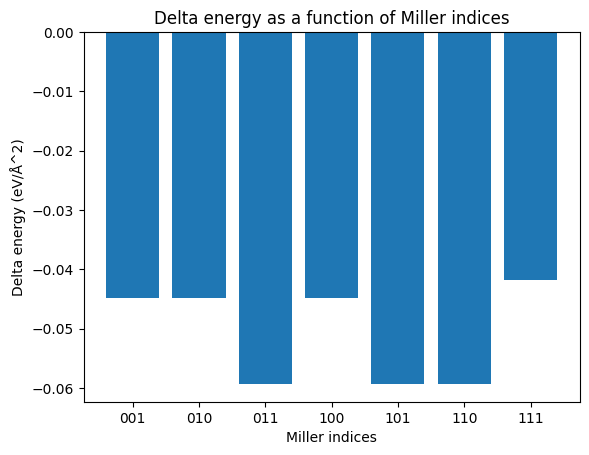

In [36]:
print(results)
import matplotlib.pyplot as plt

x = [f"{h}{k}{l}" for h, k, l in [item[0] for item in results]]
y = [item[1] for item in results]
plt.bar(x, y)
plt.xlabel("Miller indices")
plt.ylabel("Delta energy (eV/Å^2)")
plt.title("Delta energy as a function of Miller indices")
plt.show()

# 6. Return the most optimal interface

In [46]:
# Find the most optimal interface
most_optimal_index = y.index(min(y, key=abs))
most_optimal_miller_indices = x[most_optimal_index]
most_optimal_delta_energy = y[most_optimal_index]
ase_final_interface = results[most_optimal_index][2]
print(f"The most optimal interface is ({most_optimal_miller_indices}) with a delta energy of {most_optimal_delta_energy:.3f} eV/Å^2 ({most_optimal_delta_energy / 0.16:.3f} J/m^2)")
print(f"The relaxed interface is:\n{ase_to_poscar(ase_final_interface)}")

The most optimal interface is (111) with a delta energy of -0.042 eV/Å^2 (-0.261 J/m^2)
The relaxed interface is:
Ni  C 
 1.0000000000000000
     2.4600000000000000    0.0000000000000000    0.0000000000000002
     1.2300000000000002    2.1304224933097191    0.0000000000000002
     0.0000000000000000    0.0000000000000000   27.0171631781644130
 Ni  C  
   3   2
Cartesian
  2.4599999999999911  1.4202816622064687  0.4805086718857987
  3.6899999999999884  2.1304224933097120  2.5003612337408097
  1.2299999999999935  0.7101408311032270  4.5220579959329141
  1.2300000000000013  0.7101408311032407  6.4850809803120644
  2.4599999999999995  1.4202816622064773  6.0720622417039376


# 7. Visualize the interface

In [47]:
from ase.visualize import view
view(ase_final_interface*[3,3,1])


<Popen: returncode: None args: ['/Users/mat3ra/code/GREEN/api-examples/.venv...>